## Advanced Regression techniques

#LassoRegresion#Deeplearning#DealingWithManyFeatures#DataAugmentation

Hello Everyone! 
<br>
The link for this challenge is the following: https://www.kaggle.com/c/house-prices-advanced-regression-techniques


<b> Context

Use ML techniques to predict the price house
<br>
The challenge is to deal with a high number of categorical features

<b> Methodology

* Exploration
* Feature Engeniering exploring different techniques to deal with selection of categorical features
* Selecting relevant features
* Modeling using a linear regression and a simple Neural Network
* Further Feature Engeniering using Lasso Regression
* Further Modeling using an Ensemble NeuralNetwork for regression

<b> Result

Final test using Mean Logaritmic Square Error and some remarks

### General Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta  
import os
import random

from scipy.stats import chi2_contingency,chi2,ttest_ind
import statistics

from sklearn.preprocessing import MinMaxScaler,StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_log_error,mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
import scipy as sp
from scipy.stats import chi2
import math

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Data Exploration

the submission contains the forecasted prices, then I merge the submission and the Test set

In [3]:
train = pd.read_csv('train.csv')
ss = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')
test = test.merge(ss, left_on = 'Id', right_on = 'Id', how = 'inner')

In [4]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Measuring null data

Droping those that have high number of empty rows

In [5]:
def nullcalc(df,variable):
    nulls = len(df[df[variable].isna()])
    rows = len(df)
    value = round(len(df[df[variable].isna()])/len(train)*100,2)
    string =  'The column ' + variable + ' has ' + str(value) + '% of nulls'
    return string,value

In [6]:
for variable in train.columns:
    if nullcalc(train,variable)[1] > 50 :
        print(nullcalc(train,variable)[0])

The column Alley has 93.77% of nulls
The column PoolQC has 99.52% of nulls
The column Fence has 80.75% of nulls
The column MiscFeature has 96.3% of nulls


In [7]:
for variable in train.columns:
    if nullcalc(train,variable)[1] > 50 :
        print(nullcalc(train,variable)[0])

The column Alley has 93.77% of nulls
The column PoolQC has 99.52% of nulls
The column Fence has 80.75% of nulls
The column MiscFeature has 96.3% of nulls


In [8]:
todrop =['Alley','PoolQC','Fence','MiscFeature']
train = train.drop(columns = todrop)
test = test.drop(columns = todrop)

#### Feature engineering

Due to the high numbers of categorical columns, It is better to select the ones are important

In [9]:
unique_values_cond = []
objects_count = []
for column in list(train.columns):
    unique_list = list(train[column].unique())
    unique_values_cond.append(unique_list)
    objects_count.append(len(unique_list))

In [10]:
summarycolumns = pd.DataFrame({'Column':train.columns, 'UniqueValues' : unique_values_cond, 'countObjects':objects_count})

Quick tabular viz ov features and unique categories

In [11]:
summarycolumns.iloc[70:80]

,Column,UniqueValues,countObjects
70,PoolArea,"[0, 512, 648, 576, 555, 480, 519, 738]",8
71,MiscVal,"[0, 700, 350, 500, 400, 480, 450, 15500, 1200,...",21
72,MoSold,"[2, 5, 9, 12, 10, 8, 11, 4, 1, 7, 3, 6]",12
73,YrSold,"[2008, 2007, 2006, 2009, 2010]",5
74,SaleType,"[WD, New, COD, ConLD, ConLI, CWD, ConLw, Con, ...",9
75,SaleCondition,"[Normal, Abnorml, Partial, AdjLand, Alloca, Fa...",6
76,SalePrice,"[208500, 181500, 223500, 140000, 250000, 14300...",663


In [12]:
# list(summarycolumns[summarycolumns.Column == 'Exterior2nd'].UniqueValues)

In [13]:
categorical_columns = ['MSSubClass' , 'MSZoning','Street','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood',
                      'Condition1','Condition2','BldgType','HouseStyle','OverallQual','OverallCond','RoofStyle','RoofMatl','Exterior1st',
                      'Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
                      'BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
                      'BedroomAbvGr','KitchenAbvGr','KitchenQual','TotRmsAbvGrd','Functional','Fireplaces','GarageCars','PavedDrive',
                        'SaleType','SaleCondition']
special_treatment = ['YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
                    '1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch',
                    '3SsnPorch','ScreenPorch','PoolArea','MiscVal','YrSold','MoSold']

In [14]:
train['MSZoning'] = train.replace({"MSZoning": {'C (all)':'C'}}).MSZoning

Converting to categories the categorical features already listed

In [15]:
for column in categorical_columns:
    train[column] = train[column].astype('category',copy=False)
    test[column] = test[column].astype('category',copy=False)

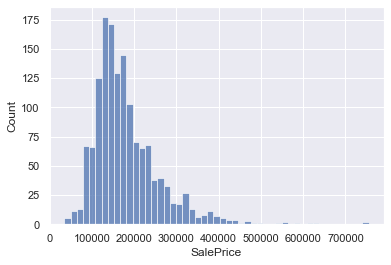

In [16]:
sns.histplot( data=train, x="SalePrice")

This is the targuet distribution

Null plot for categoricals and numericals

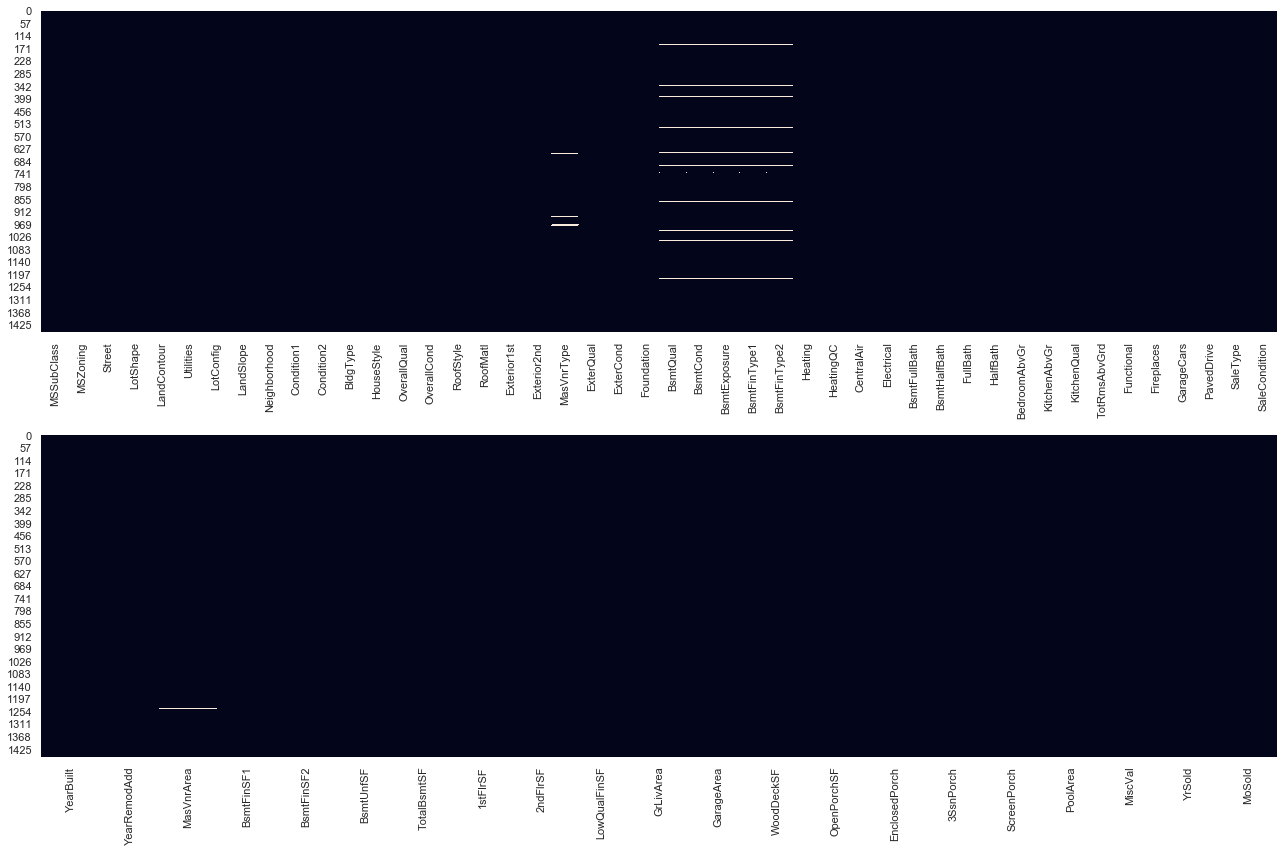

In [17]:
a4_dims = (18, 12)
fig, axs = plt.subplots(2,1, figsize=a4_dims)
sns.heatmap( ax = axs[0], data = train[categorical_columns].isnull() , cbar=False)
sns.heatmap( ax = axs[1], data = train[special_treatment].isnull() , cbar=False)
fig.tight_layout()

Distributions by categories for each categorical variable

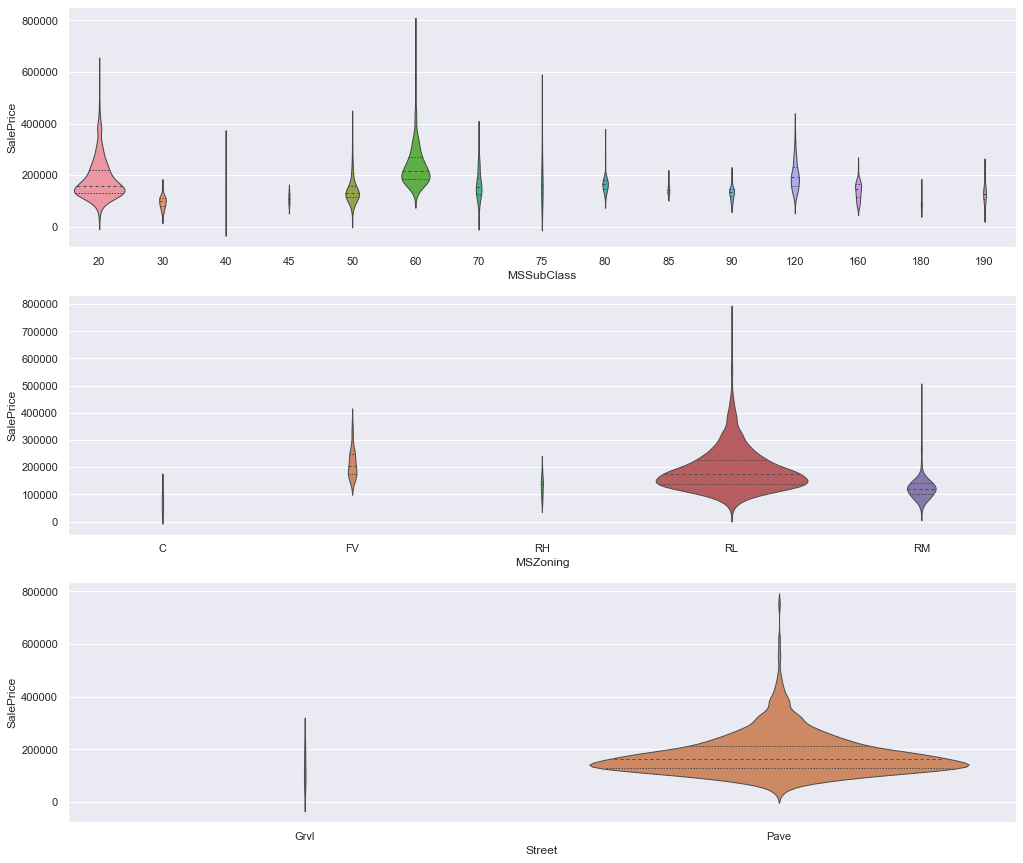

In [18]:
a4_dims = (17.0, 15.0)
fig, ax = plt.subplots(3,1,figsize=a4_dims)

sns.violinplot(ax = ax[0], data=train, x=categorical_columns[0], y="SalePrice",split=True, inner="quart", linewidth=1,scale="count")
sns.violinplot(ax = ax[1], data=train, x=categorical_columns[1], y="SalePrice",split=True, inner="quart", linewidth=1,scale="count")
sns.violinplot(ax = ax[2], data=train, x=categorical_columns[2], y="SalePrice",split=True, inner="quart", linewidth=1,scale="count")

<b> Using Mean Encoding to remove correlated categorical columns

In [19]:
train_mod = train.copy()

In [20]:
for col in categorical_columns:
    feq = train_mod.groupby(col)['SalePrice'].mean()
    train_mod.loc[:,col] = train_mod [col].map(feq)
    
train_cat = train_mod[categorical_columns]
for column in categorical_columns:
    train_cat[column] = train_cat[column].astype('float',copy=False)
train_cat = train_cat.fillna(0)

to_drop = ['Exterior2nd','BsmtQual','BsmtFinType2','BsmtFinType1','SaleCondition',
          'BsmtExposure','MSSubClass','Neighborhood','ExterQual','KitchenAbvGr','BedroomAbvGr','Utilities','Street','PavedDrive','CentralAir',
          'Condition2','RoofMatl','Electrical','Heating','Functional','LandSlope','BsmtHalfBath','BsmtCond','LandContour','ExterCond',
           'SaleType','Condition1','BldgType','MSZoning','RoofStyle','LotConfig',
          'OverallCond','Exterior1st','LotShape','HeatingQC','TotRmsAbvGrd']

train_cat = train_cat.drop(columns = to_drop)

The following table shows the columns already selected

In [21]:
list_col = list(train_cat.columns)
random.shuffle(list_col)
train_cat[ list_col[10:20] ].corr().round(2)

""


<b> Final shape of train set

In [22]:
def Converting_table(data, Listnumerical, categorical_col):
    def_data = data.assign(edad = data['YrSold'] - data['YearRemodAdd'] )[categorical_col + Listnumerical  + ['SalePrice']]
    for col in categorical_col:
        def_data[col] = def_data[col].astype(str)
        def_data[col] = def_data[col].astype('category',copy=False)
        def_data[col] = def_data[col].cat.add_categories('Unknown')
        def_data[col].fillna('Unknown', inplace =True)
    for col in Listnumerical:
        def_data[col] = def_data[col].fillna(0)
    return def_data

In [23]:
vars_numeric = ['LotFrontage','BsmtFinSF1','BsmtUnfSF','TotalBsmtSF','GrLivArea','GarageYrBlt','GarageArea','edad']

In [24]:
def_train = Converting_table(train, vars_numeric, list_col)

In [25]:
def_train

,OverallQual,Fireplaces,HalfBath,Foundation,KitchenQual,MasVnrType,BsmtFullBath,HouseStyle,FullBath,GarageCars,LotFrontage,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,GrLivArea,GarageYrBlt,GarageArea,edad,SalePrice
0,7,0,1,PConc,Gd,BrkFace,1,2Story,2,2,65.0,706,150,856,1710,2003.0,548,5,208500
1,6,1,0,CBlock,TA,None,0,1Story,2,2,80.0,978,284,1262,1262,1976.0,460,31,181500
2,7,1,1,PConc,Gd,BrkFace,1,2Story,2,2,68.0,486,434,920,1786,2001.0,608,6,223500
3,7,1,0,BrkTil,Gd,None,1,2Story,1,3,60.0,216,540,756,1717,1998.0,642,36,140000
4,8,1,1,PConc,Gd,BrkFace,1,2Story,2,3,84.0,655,490,1145,2198,2000.0,836,8,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,6,1,1,PConc,TA,None,0,2Story,2,2,62.0,0,953,953,1647,1999.0,460,7,175000
1456,6,2,0,CBlock,TA,Stone,1,1Story,2,2,85.0,790,589,1542,2073,1978.0,500,22,210000
1457,7,2,0,Stone,Gd,None,0,2Story,2,1,66.0,275,877,1152,2340,1941.0,252,4,266500
1458,5,0,0,CBlock,Gd,None,1,1Story,1,1,68.0,49,0,1078,1078,1950.0,240,14,142125


In [26]:
def_train[vars_numeric + ['SalePrice']].corr() 

,LotFrontage,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,GrLivArea,GarageYrBlt,GarageArea,edad,SalePrice
LotFrontage,1.000000,0.076670,0.160829,0.238274,0.220347,0.019317,0.201473,-0.079482,0.209624
BsmtFinSF1,0.076670,1.000000,-0.495251,0.522396,0.208171,0.115843,0.296970,-0.127556,0.386420
BsmtUnfSF,0.160829,-0.495251,1.000000,0.415360,0.240257,0.042720,0.183303,-0.183830,0.214479
TotalBsmtSF,0.238274,0.522396,0.415360,1.000000,0.454868,0.176359,0.486665,-0.292096,0.613581
GrLivArea,0.220347,0.208171,0.240257,0.454868,1.000000,0.162543,0.468997,-0.289805,0.708624
GarageYrBlt,0.019317,0.115843,0.042720,0.176359,0.162543,1.000000,0.560783,-0.147107,0.261366
GarageArea,0.201473,0.296970,0.183303,0.486665,0.468997,0.560783,1.000000,-0.373447,0.623431
edad,-0.079482,-0.127556,-0.183830,-0.292096,-0.289805,-0.147107,-0.373447,1.000000,-0.509079
SalePrice,0.209624,0.386420,0.214479,0.613581,0.708624,0.261366,0.623431,-0.509079,1.000000


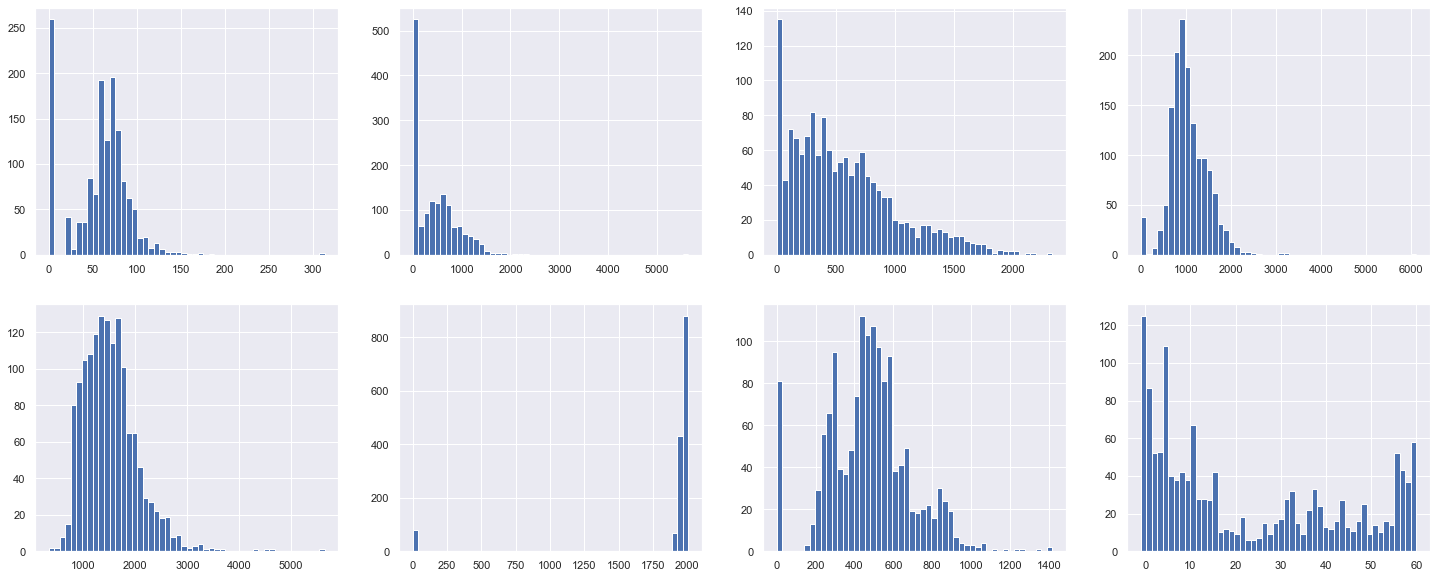

In [27]:
fig, axs = plt.subplots(nrows=2, ncols=4,figsize=(25,10))
rows = [0,0,0,0,1,1,1,1]
cols =[0,1,2,3,0,1,2,3]
for var,row,col in zip(vars_numeric,rows,cols): 
    axs[row,col].hist(def_train[var], bins=50)

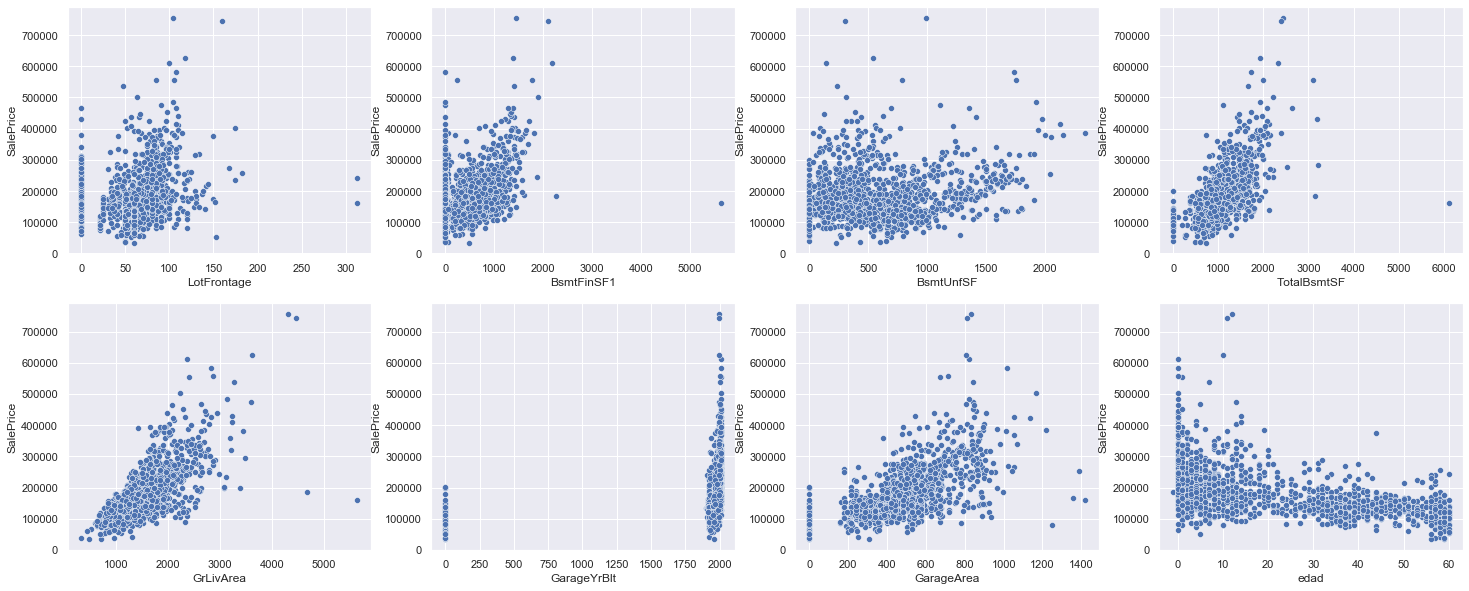

In [28]:
fig, axs = plt.subplots(nrows=2, ncols=4,figsize=(25,10))
rows = [0,0,0,0,1,1,1,1]
cols =[0,1,2,3,0,1,2,3]
for var,row,col in zip(vars_numeric,rows,cols): 
    sns.scatterplot(ax = axs[row,col] ,data = def_train, x = var, y = "SalePrice")

### What is it needed to improve power prediction?

<b> Explore the variables that are not sparse (if possible) -> Less  dimensionality

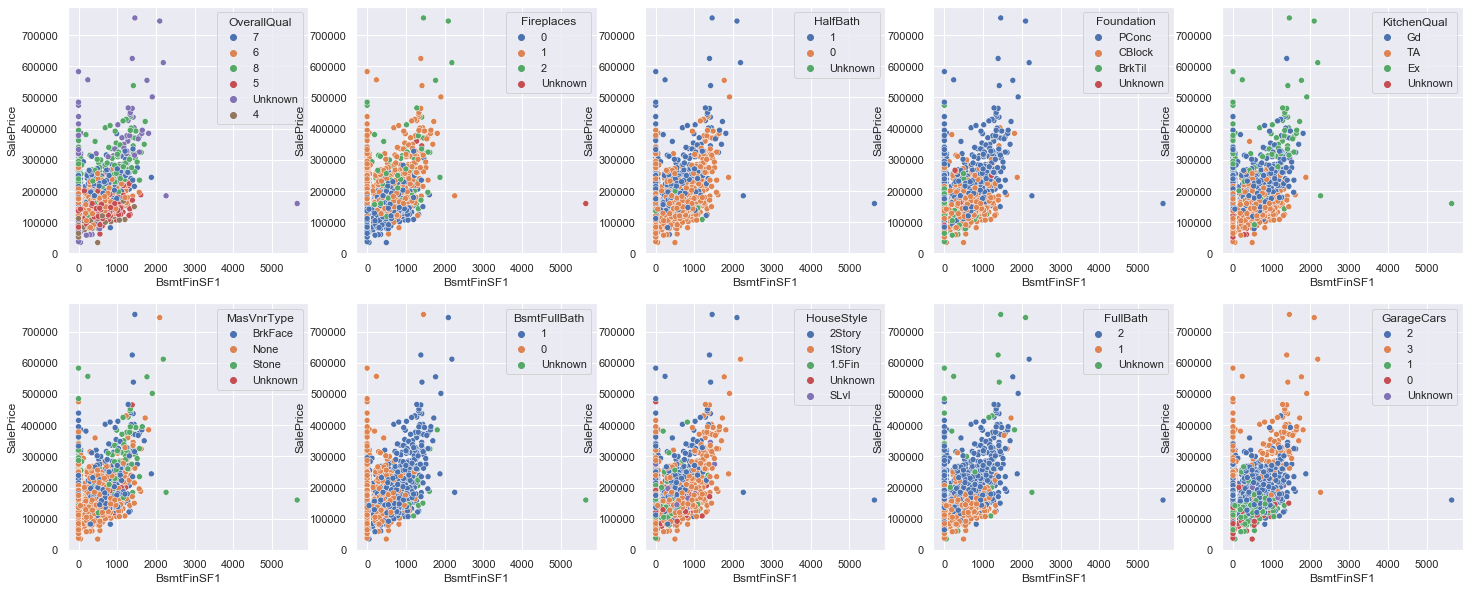

In [295]:
fig, axs = plt.subplots(nrows=2, ncols=5,figsize=(25,10))
rows = [0,0,0,0,0,1,1,1,1,1]
cols =[0,1,2,3,4,0,1,2,3,4]
for var,row,col in zip(list_col,rows,cols):
    sns.scatterplot(ax = axs[row,col] ,data = def_train, x = vars_numeric[1], y = "SalePrice", hue = var)

In [296]:
indx = 8
(list_col[indx],list(def_train[list_col[indx]].unique()))

('FullBath', ['2', '1', 'Unknown'])

In [29]:
## My numerics
'GrLivArea','GarageArea','edad'

('GrLivArea', 'GarageArea', 'edad')

In [30]:
## My model variables

In [317]:
(vars_numeric[4], 'KitchenQual' ,[list(def_train['KitchenQual'].unique())[x] for x in [0,1,2]]),
(vars_numeric[6], 'GarageCars' ,[list(def_train['GarageCars'].unique())[x] for x in [0,1,2,3]]),
(vars_numeric[7], 'GarageCars' ,[list(def_train['GarageCars'].unique())[x] for x in [0,1,2,3]]),
(vars_numeric[1], 'FullBath' ,[list(def_train['FullBath'].unique())[x] for x in [0,1]])

('BsmtFinSF1', 'FullBath', ['2', '1'])

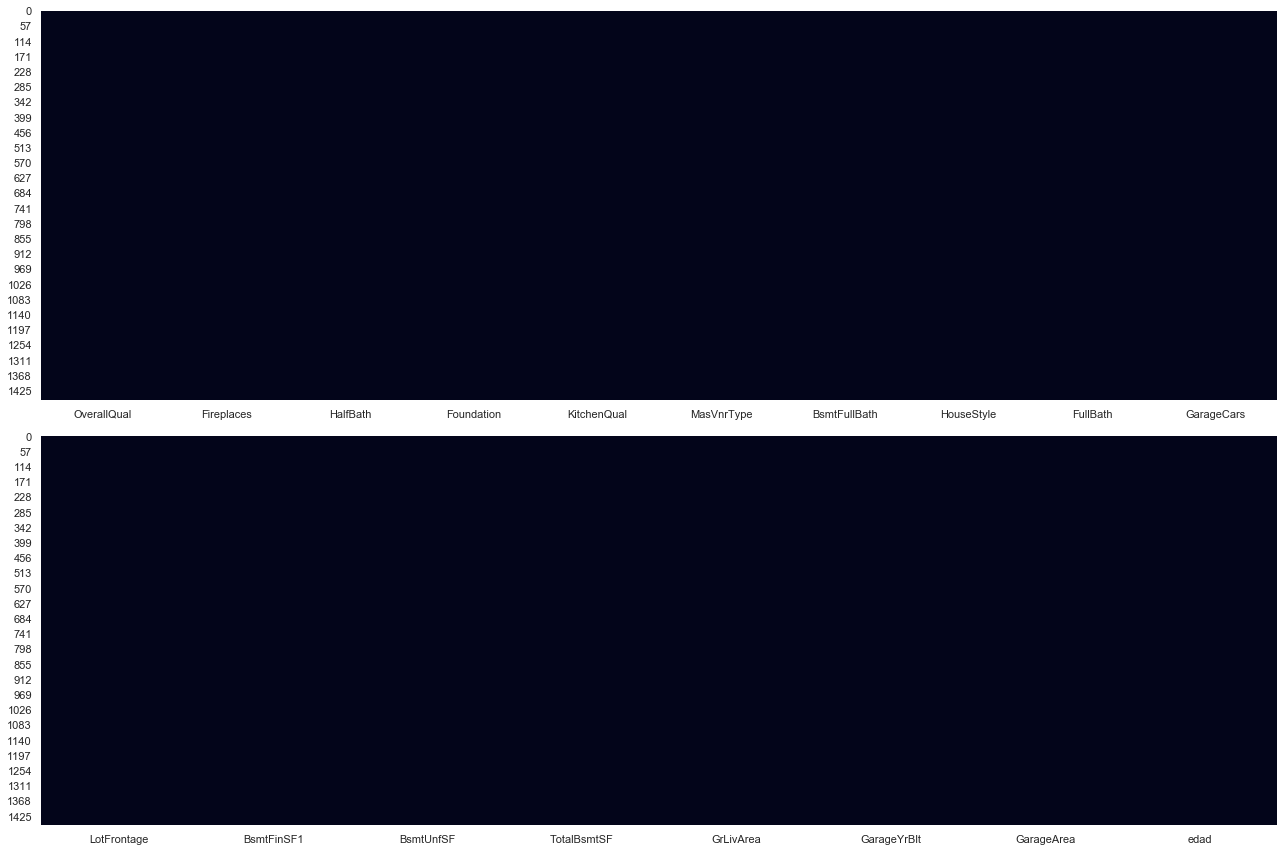

In [32]:
a4_dims = (18, 12)
fig, axs = plt.subplots(2,1, figsize=a4_dims)
sns.heatmap( ax = axs[0], data = def_train[list_col].isnull() , cbar=False)
sns.heatmap( ax = axs[1], data = def_train[vars_numeric].isnull() , cbar=False)
fig.tight_layout()

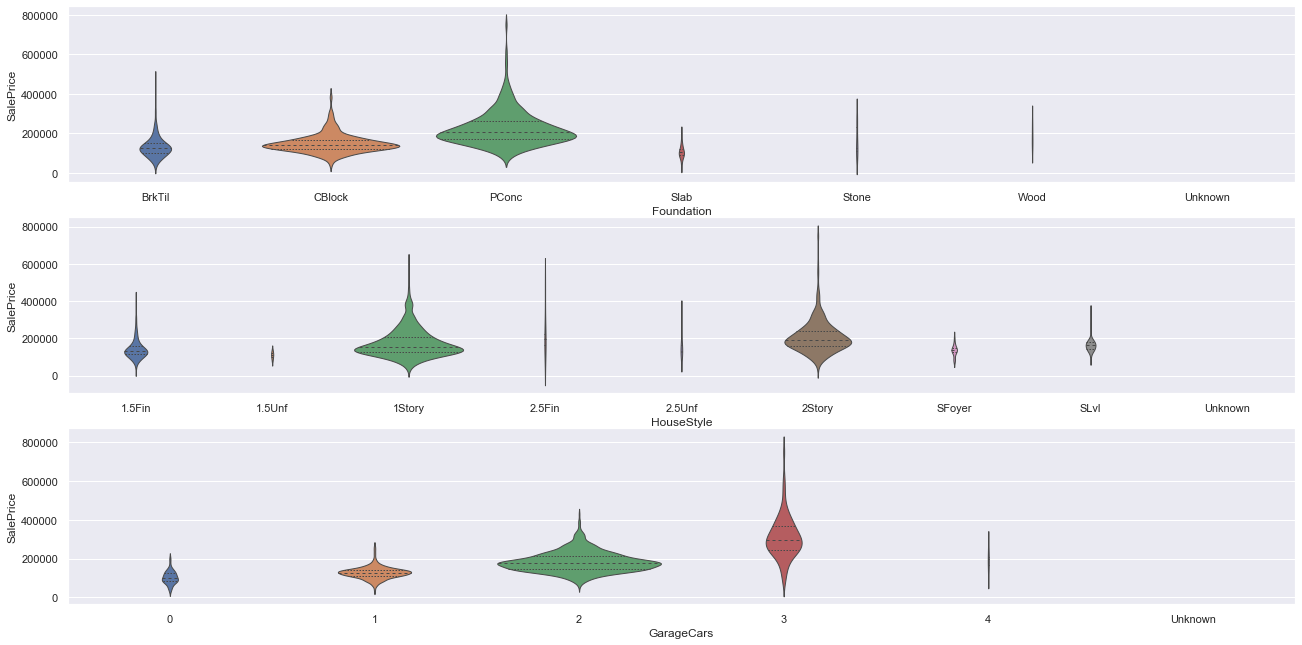

In [33]:
a4_dims = (22.0, 11.0)
fig, ax = plt.subplots(3,1,figsize=a4_dims)

sns.violinplot(ax = ax[0], data=def_train, x=list_col[3], y="SalePrice",split=True, inner="quart", linewidth=1,scale="count")
sns.violinplot(ax = ax[1], data=def_train, x=list_col[7], y="SalePrice",split=True, inner="quart", linewidth=1,scale="count")
sns.violinplot(ax = ax[2], data=def_train, x=list_col[9], y="SalePrice",split=True, inner="quart", linewidth=1,scale="count")

In [34]:
total = 0
for col in def_train[list_col].columns:
    total = total + len(def_train[col].unique())
total

53

Too many features or individual categories

In [35]:
df_total =[]
for col in def_train[list_col].columns:
    df = train.groupby(col)[['Id']].count().reset_index().rename(columns = {col:'Category'})
    df['Feature'] = col
    df_total.append(df)
df_total = pd.concat(df_total)

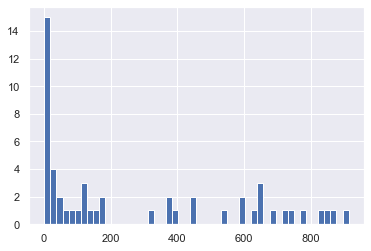

In [36]:
df_total.Id.hist(bins = 50)

many features or categories with very few observations

The following dictionary will consolidate the very few features

In [37]:
col = list_col[0]
df = def_train.groupby(col)[['SalePrice']].count().reset_index()
dicttocol = df.drop(columns = 'SalePrice').to_dict('list')

for col in list_col[1:]:
    df = def_train.groupby(col)[['SalePrice']].count().reset_index()
    dicttocol[col] = list(df.drop(columns = 'SalePrice')[col])

In [38]:
cutoff = 50
col = list_col[0]
df = def_train.groupby(col)[['SalePrice']].count().reset_index()
dicttocons = df[df.SalePrice <= cutoff].drop(columns = 'SalePrice').to_dict('list')

for col in list_col[1:]:
    df = def_train.groupby(col)[['SalePrice']].count().reset_index()
    dicttocons[col] = list(df[df.SalePrice <= cutoff].drop(columns = 'SalePrice')[col])

In [39]:
def converting_treating_categorical(data,gendict, todropdict):
    for col in list(gendict.keys()):
        catcol = list(data[col].unique())
        catdict = dicttocol[col]
        new_features = [x  for x in catcol if x not in catdict]
        default = ['Unknown' for x in new_features]
        to_change = dict(zip(new_features, default))
        
        if new_features:
            data = data.replace({col: to_change})
            
    for col in list(todropdict.keys()):
        features = todropdict[col]
        default = ['Unknown' for x in features]
        to_change = dict(zip(features, default))
        data = data.replace({col: to_change})
        
    return data

In [40]:
def_train = converting_treating_categorical(def_train,dicttocol,dicttocons)
total = 0
for col in def_train[list_col].columns:
    total = total + len(def_train[col].unique())
total

41

In [41]:
df_total =[]
for col in def_train[list_col].columns:
    df = def_train.groupby(col)[['SalePrice']].count().reset_index().rename(columns = {col:'Category'})
    df['Feature'] = col
    df_total.append(df)
df_total = pd.concat(df_total)

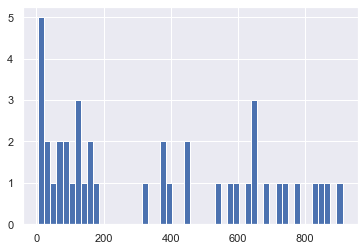

In [42]:
df_total.SalePrice.hist(bins = 50)

### Multiplicative Lineal Regression - Lasso Regression

In [43]:
from sklearn.linear_model import Ridge, Lasso

In [541]:
trainset = def_train.copy()

In [542]:
def_test = Converting_table(test, vars_numeric, list_col)
def_test = converting_treating_categorical(def_test,dicttocol,dicttocons)

In [543]:
def augment_numerical(data,n):
    columns_to_noise = vars_numeric + ['SalePrice']
    aggmented_data_list = []
    newData = n
    for i in range(newData):
        uni = data.sample(1)
        unidict = uni.to_dict('r')[0]

        for col in columns_to_noise:
            beta = 0.04
            IQR = IQRdicts[col]
            space = np.random.uniform(-IQR*beta,IQR*beta,1)[0]
            value = unidict[col]
            unidict[col] = value + space
        aggmented_data_list.append(unidict)

    aggmented_data_dict = {}
    example = aggmented_data_list[0]
    varx = [[] for x in range(len(example.keys()))]

    for dct in aggmented_data_list:
        for key, x in zip(example.keys(), range(len(example.keys())) ):
            val = dct[key]
            varx[x].append(val)

    dictionary = dict(zip(aggmented_data_list[0].keys(), varx))
    aggmented_data = pd.DataFrame.from_dict(dictionary)
    return aggmented_data

In [544]:
split = 0.45
total_rows = len(trainset)
rows_toval = math.ceil( total_rows*split)
wholeindex = list(range(total_rows))
valindexs = list(np.random.choice(wholeindex, size=rows_toval, replace=False))
trainindexs = [x for x in wholeindex if x not in valindexs]

In [545]:
trainSet = trainset.iloc[trainindexs,:]
validationSet = trainset.iloc[valindexs,:]

In [546]:
## IQRs
q1 = trainset['SalePrice'].quantile(0.25)
q3 = trainset['SalePrice'].quantile(0.75)
IQR = q3 - q1
IQRdicts = {'SalePrice':IQR}

for col in trainset[vars_numeric ].columns:
    q1 = trainset[col].quantile(0.25)
    q3 = trainset[col].quantile(0.75)
    IQR = q3 - q1
    IQRdicts[col] = IQR

In [547]:
aggmented_data = augment_numerical(data=trainSet ,n = 3000)

In [548]:
trainComplete = pd.concat([trainSet,aggmented_data])
trainComplete.shape

(3803, 19)

In [549]:
# model_variables 

In [550]:
wow = [(vars_numeric[4], 'KitchenQual' ,[list(def_train['KitchenQual'].unique())[x] for x in [0,1,2]]),
(vars_numeric[6], 'GarageCars' ,[list(def_train['GarageCars'].unique())[x] for x in [0,1,2,3]]),
(vars_numeric[7], 'GarageCars' ,[list(def_train['GarageCars'].unique())[x] for x in [0,1,2,3]]),
(vars_numeric[1], 'FullBath' ,[list(def_train['FullBath'].unique())[x] for x in [0,1]])] #

In [551]:
vars_numeric_v2 = [vars_numeric[4],vars_numeric[7],vars_numeric[6]]

In [552]:
def modeling_list(genfeat ,listcol , numeric):
    list_columns_generalselect = []
    variable_list = []
    for dummy in listcol:
        dum = genfeat +'_'+dummy
        name = genfeat +'_'+dummy+'_'+numeric
        variable_list.append(name)
        list_columns_generalselect.append(dum)
    used = set()
    mylist = list_columns_generalselect
    list_columns_generalselect = [x for x in mylist if x not in used and (used.add(x) or True)]
    return list_columns_generalselect,variable_list

In [553]:
list_columns_generalselect = []
list_columns_multiplicative = []
for tup in wow:
    x, y = modeling_list(genfeat = tup[1],listcol =tup[2] , numeric =tup[0])
    list_columns_generalselect.append(x)
    list_columns_multiplicative.append(y)
    
list_to_trqns = []
for x in list_columns_generalselect:
    for ele in x:
        list_to_trqns.append(ele)
used = set()
mylist = list_to_trqns
list_columns_generalselect = [x for x in mylist if x not in used and (used.add(x) or True)]

list_to_trqns = []
for x in list_columns_multiplicative:
    for ele in x:
        list_to_trqns.append(ele)
used = set()
mylist = list_to_trqns
list_columns_multiplicative = [x for x in mylist if x not in used and (used.add(x) or True)]

In [554]:
len(list_columns_generalselect) + len(list_columns_multiplicative) + len(vars_numeric_v2)

25

In [555]:
def mult_dummizing_data(data, selecteddummies, selectedMultDummies ,MaxFeature, MaxMultDummies):
    data = data.copy()
    if not selecteddummies:
        dummies = pd.get_dummies(data[list_col])
        dummies_cols = list(dummies.columns)
        new_data = pd.concat([dummies,data[vars_numeric + ['SalePrice']]],axis = 1)
        random.shuffle(dummies_cols)
        selectdummies = dummies_cols[0:MaxFeature]
        
    else:
        dummies = pd.get_dummies(data[list_col])
        new_data = pd.concat([dummies,data[vars_numeric + ['SalePrice']]],axis = 1)
        selectdummies = selecteddummies
        
        missingcolumns = [x for x in selectdummies if x not in new_data.columns]
        for col in missingcolumns:
            new_data[col] = 0
    
    
    if not selectedMultDummies:
        multcolumns = []
        for coldummy in selectdummies:
            for colnumeric in vars_numeric:
                name = coldummy+'_'+colnumeric
                multcolumns.append(name)
                try:
                    new_data[name] = new_data[coldummy]*new_data[colnumeric]
                except:
                    new_data[name] = 0
        random.shuffle(multcolumns)
        multcolumns = multcolumns[0:MaxMultDummies]
    else:
        for coldummy in selectdummies:
            for colnumeric in vars_numeric:
                name = coldummy+'_'+colnumeric
                #multcolumns.append(name)
                try:
                    new_data[name] = new_data[coldummy]*new_data[colnumeric]
                except:
                    new_data[name] = 0
        multcolumns = selectedMultDummies
    
    multTrainset = new_data[selectdummies + multcolumns +vars_numeric_v2 + ['SalePrice']] #
    return multTrainset, selectdummies, multcolumns

In [556]:
multTrainset, selectdummies, multcolumns = mult_dummizing_data(data = trainComplete, selecteddummies =list_columns_generalselect ,selectedMultDummies = list_columns_multiplicative, MaxFeature = 1000,MaxMultDummies=1500)
multValidationSet, _,_ = mult_dummizing_data(data = validationSet, selecteddummies = selectdummies,selectedMultDummies=multcolumns,MaxFeature = 1000,MaxMultDummies=1500)
multTestSet, _,_ =  mult_dummizing_data(data = def_test, selecteddummies = selectdummies,selectedMultDummies=multcolumns,MaxFeature = 1000,MaxMultDummies=1500)

In [557]:
multTrainset.shape,multValidationSet.shape, multTestSet.shape

((3803, 26), (657, 26), (1459, 26))

In [558]:
X__train  = multTrainset.iloc[:,0:-1]
y_train = multTrainset.iloc[:,-1]
X__val = multValidationSet.iloc[:,0:-1]
y_val = multValidationSet.iloc[:,-1]

X_test = multTestSet.iloc[:,0:-1]
Y_test = multTestSet.iloc[:,-1]

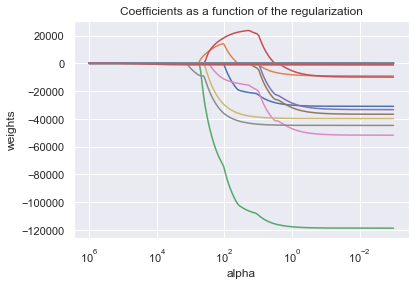

In [559]:
n_alphas = 200
alphas = np.logspace(-3, 6, n_alphas)

coefs = []
for a in alphas:
    linearModel = Lasso(alpha=a, fit_intercept=True)
    linearModel.fit(X__train, y_train)
    coefs.append(linearModel.coef_)

# #############################################################################
# Display results
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [560]:
linearModel = Lasso(alpha=(10 ** (-1)), fit_intercept=True)
linearModel.fit(X__train, y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [561]:
y_pred = linearModel.predict(X__train)
df = pd.DataFrame({'y_train': y_train, 'y_pred':y_pred.reshape((y_pred.shape[0],))})
df = df.assign(error = df.y_pred - df.y_train)

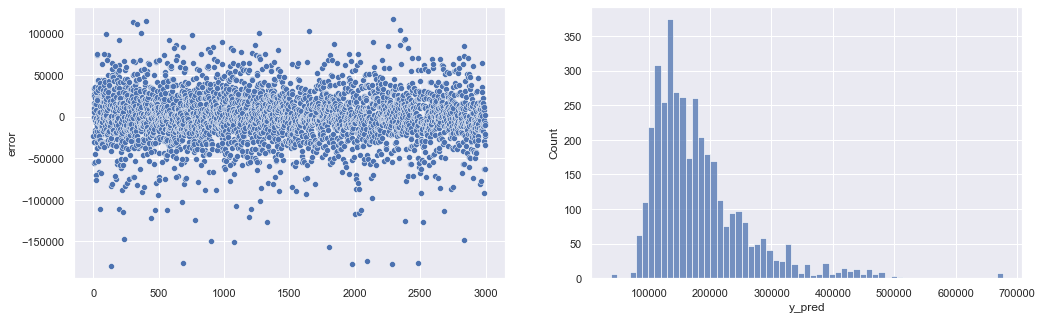

In [562]:
fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(17,5))

sns.scatterplot(ax = axs[0] ,data = df, x = df.index, y = 'error')
sns.histplot(ax = axs[1] , data=df, x="y_pred")

<b> validation

In [563]:
y_pred = linearModel.predict(X__val) 

In [564]:
mean_squared_log_error(y_val,y_pred)

0.03698891246519789

In [565]:
mean_absolute_error(y_val,y_pred)

23952.29533551191

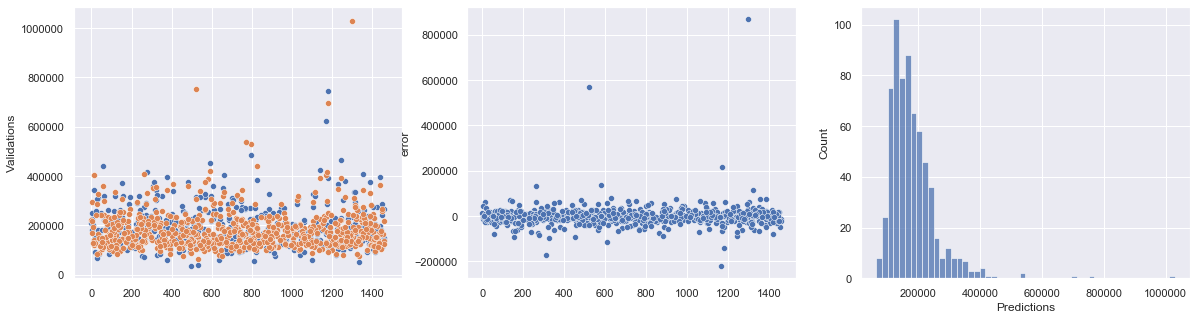

In [566]:
pfplot = pd.DataFrame({'Id':range(y_val.shape[0]),'Validations':y_val,'Predictions':y_pred.reshape((y_pred.shape[0],))})
pfplot = pfplot.assign(error = pfplot.Predictions - pfplot.Validations)

fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(20,5))

sns.scatterplot(ax = axs[0] ,data = pfplot, x = pfplot.index, y = 'Validations')
sns.scatterplot(ax = axs[0] ,data = pfplot, x = pfplot.index, y = 'Predictions')
sns.scatterplot(ax = axs[1] ,data = pfplot, x = pfplot.index, y = 'error')
sns.histplot(ax = axs[2] , data= pfplot, x="Predictions")

<b> Evaluating test

In [567]:
y_pred = linearModel.predict(X_test)

In [568]:
mean_squared_log_error(Y_test,y_pred)

0.06672365367706568

In [569]:
mean_absolute_error(Y_test,y_pred)

39115.39698685721

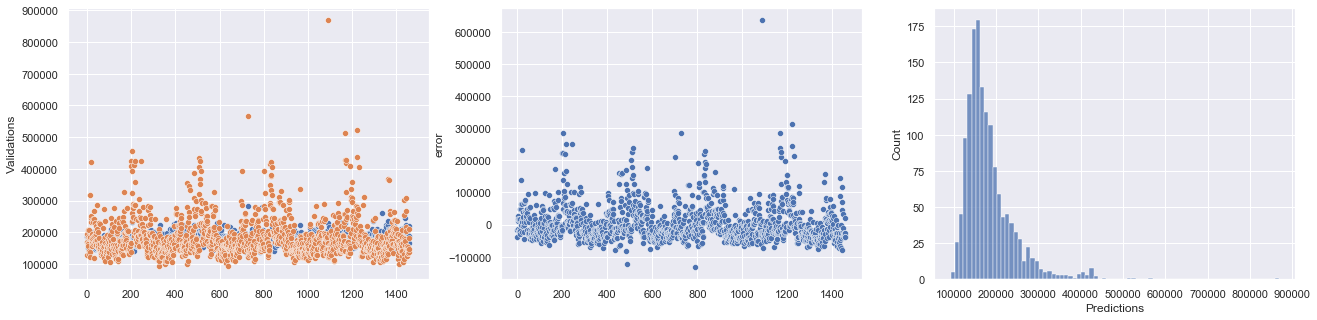

In [570]:
pfplot = pd.DataFrame({'Id':range(Y_test.shape[0]),'Validations':Y_test,'Predictions':y_pred.reshape((y_pred.shape[0],))})
pfplot = pfplot.assign(error = pfplot.Predictions - pfplot.Validations)

fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(22,5))

sns.scatterplot(ax = axs[0] ,data = pfplot, x = pfplot.index, y = 'Validations')
sns.scatterplot(ax = axs[0] ,data = pfplot, x = pfplot.index, y = 'Predictions')
sns.scatterplot(ax = axs[1] ,data = pfplot, x = pfplot.index, y = 'error')
sns.histplot(ax = axs[2] , data= pfplot, x="Predictions")

In [573]:
dictdata = {'Id':test['Id'],'SalePrice':pfplot.Predictions}
pd.DataFrame(dictdata).to_csv('Predictions_v5.csv',index=False)

### Deep Learning Libraries

In [270]:
import tensorflow as tf
from tensorflow import keras
tf.__version__

'2.0.0-alpha0'

In [494]:
from tensorflow.keras import regularizers,initializers

### Testing Network

In [574]:
multTrainset, selectdummies, multcolumns = mult_dummizing_data(data = trainComplete, selecteddummies =list_columns_generalselect ,selectedMultDummies = list_columns_multiplicative, MaxFeature = 1000,MaxMultDummies=1500)
multValidationSet, _,_ = mult_dummizing_data(data = validationSet, selecteddummies = selectdummies,selectedMultDummies=multcolumns,MaxFeature = 1000,MaxMultDummies=1500)
multTestSet, _,_ =  mult_dummizing_data(data = def_test, selecteddummies = selectdummies,selectedMultDummies=multcolumns,MaxFeature = 1000,MaxMultDummies=1500)

In [575]:
multTrainset.shape,multValidationSet.shape, multTestSet.shape

((3803, 26), (657, 26), (1459, 26))

In [576]:
scaler = MinMaxScaler()
scaler.fit(multTrainset)

multTrainset_scaled = scaler.transform(multTrainset)
multValidationSet_scaled = scaler.transform(multValidationSet)
multTestSet_scaled = scaler.transform(multTestSet)

In [577]:
X__train  = multTrainset_scaled[:,0:-1]
y_train = multTrainset_scaled[:,-1]
X__val = multValidationSet_scaled[:,0:-1]
y_val = multValidationSet_scaled[:,-1]

X_test = multTestSet_scaled[:,0:-1]
Y_test = multTestSet_scaled[:,-1]

In [642]:
keras.backend.clear_session()
model = keras.Sequential()
model.add(keras.layers.Dense(1, input_dim = X__train.shape[1], activation='linear'
                             ,kernel_initializer=initializers.RandomNormal(stddev=0.1,mean=0.0)
                             ,bias_initializer=initializers.RandomNormal(stddev=0.05,mean=0.70)
                             , kernel_regularizer=regularizers.l2(0.02)))
opt = keras.optimizers.SGD(learning_rate=0.025)

model.compile(loss='mse', optimizer = opt, metrics = ['mse'])

In [643]:
simple_model = model.fit(X__train,y_train,epochs = 80, verbose = 0, validation_split = 0.55, batch_size = 150 ,shuffle = True)
model.summary()
model.metrics_names

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 26        
Total params: 26
Trainable params: 26
Non-trainable params: 0
_________________________________________________________________


['loss', 'mse']

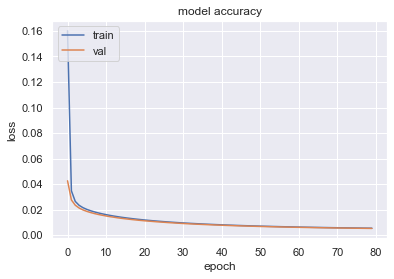

In [644]:
plt.plot(simple_model.history['loss'])
plt.plot(simple_model.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

<b> Verifying regression

In [645]:
y_pred = model.predict(X__train)
pred = scaler.inverse_transform(np.concatenate((X__train, y_pred.reshape((y_pred.shape[0],1))), axis=1))
valdf = scaler.inverse_transform(np.concatenate((X__train, y_train.reshape((y_train.shape[0],1))), axis=1))

In [646]:
predictions = pred[:,-1]
validations = valdf[:,-1]
df = pd.DataFrame({'y_train': validations, 'y_pred':predictions})
df = df.assign(error = df.y_pred - df.y_train)

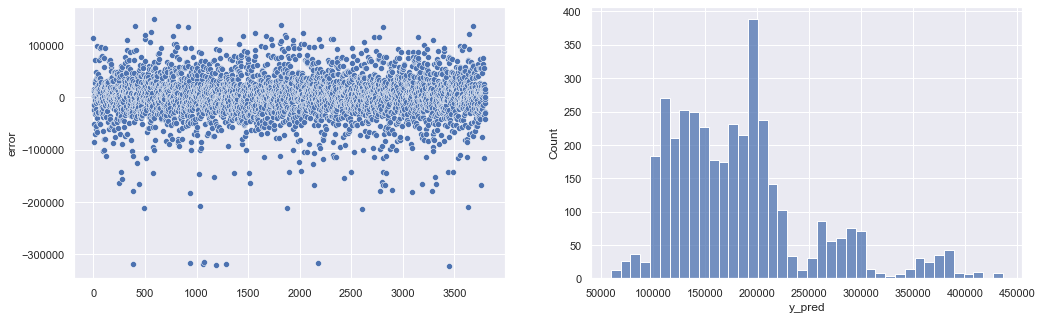

In [647]:
fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(17,5))

sns.scatterplot(ax = axs[0] ,data = df, x = df.index, y = 'error')
sns.histplot(ax = axs[1] , data=df, x="y_pred")

<b> validation

In [648]:
y_pred = model.predict(X__val)
pred = scaler.inverse_transform(np.concatenate((X__val, y_pred.reshape((y_pred.shape[0],1))), axis=1))
valdf = scaler.inverse_transform(np.concatenate((X__val, y_val.reshape((y_val.shape[0],1))), axis=1))

In [649]:
predictions = pred[:,-1]
validations = valdf[:,-1]
df = pd.DataFrame({'y_val': validations, 'y_pred':predictions})
df = df.assign(error = df.y_pred - df.y_val)
df['Id'] = range(y_val.shape[0])

In [650]:
mean_squared_log_error(df.y_val,df.y_pred)

0.06162524881250818

In [651]:
mean_absolute_error(df.y_val,df.y_pred)

31456.46495455957

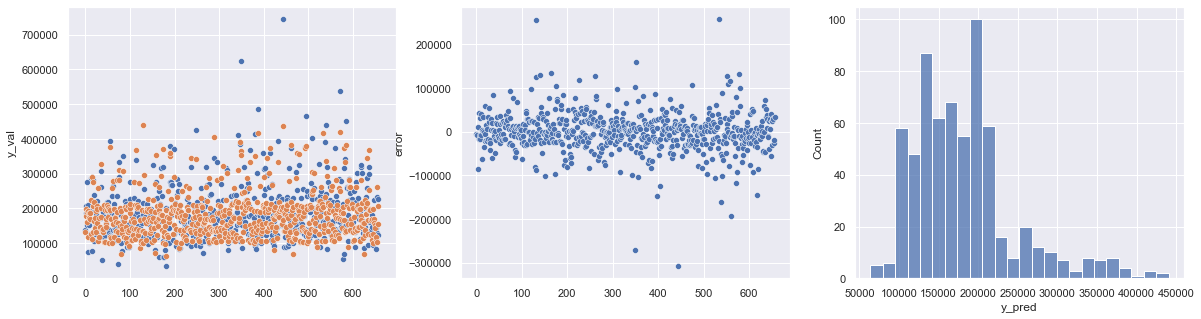

In [652]:
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(20,5))

sns.scatterplot(ax = axs[0] ,data = df, x = df.index, y = 'y_val')
sns.scatterplot(ax = axs[0] ,data = df, x = df.index, y = 'y_pred')
sns.scatterplot(ax = axs[1] ,data = df, x = df.index, y = 'error')
sns.histplot(ax = axs[2] , data= df, x="y_pred")

<b> Evaluating test

In [653]:
y_pred = model.predict(X_test)
pred = scaler.inverse_transform(np.concatenate((X_test, y_pred.reshape((y_pred.shape[0],1))), axis=1))
valdf = scaler.inverse_transform(np.concatenate((X_test, Y_test.reshape((Y_test.shape[0],1))), axis=1))

In [654]:
predictions = pred[:,-1]
validations = valdf[:,-1]
df = pd.DataFrame({'y_test': validations, 'y_pred':predictions})
df = df.assign(error = df.y_pred - df.y_test)
df['Id'] = range(Y_test.shape[0])

In [655]:
mean_squared_log_error(df.y_test,df.y_pred)

0.06590398242794966

In [656]:
mean_absolute_error(df.y_test,df.y_pred)

42090.94069232115

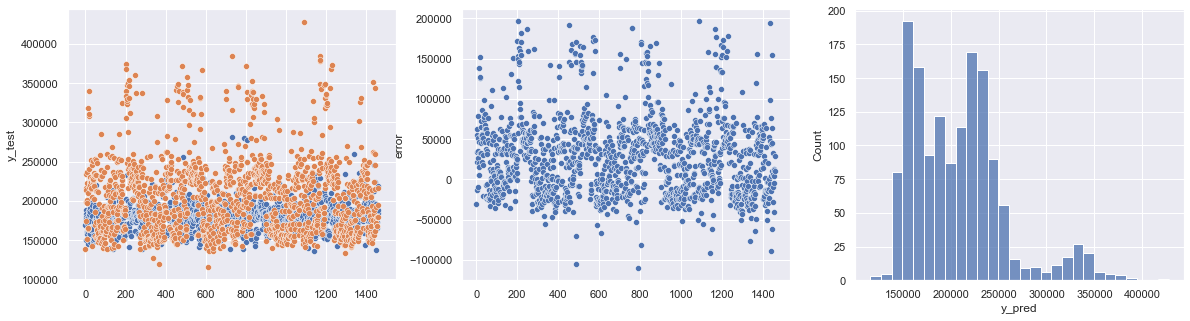

In [657]:
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(20,5))

sns.scatterplot(ax = axs[0] ,data = df, x = df.index, y = 'y_test')
sns.scatterplot(ax = axs[0] ,data = df, x = df.index, y = 'y_pred')
sns.scatterplot(ax = axs[1] ,data = df, x = df.index, y = 'error')
sns.histplot(ax = axs[2] , data= df, x="y_pred")

In [528]:
dictdata = {'Id':test['Id'],'SalePrice':df.y_pred}
pd.DataFrame(dictdata).to_csv('Predictions_v5.csv',index=False)

In [342]:
#model.save('model_multiplicativeNN.h5')

----

## Last best prediction

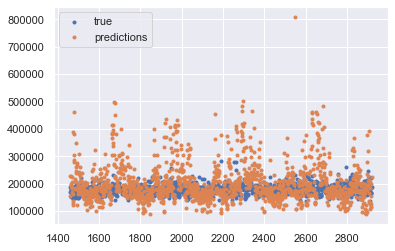

In [84]:
best = pd.read_csv('Predictions_v4.csv').rename(columns = {'SalePrice' : 'predictions'} )
best = best.merge(test[['Id','SalePrice']], left_on  = 'Id', right_on = 'Id', how = 'inner').rename(columns = {'SalePrice' : 'true'} )
plt.scatter(best.Id,best.true,marker = '.',label = 'true')
plt.scatter(best.Id,best.predictions,marker = '.', label = 'predictions')
plt.legend(loc="upper left")

In [85]:
Y_test = best.true
y_pred_unscaled = best.predictions

In [86]:
mean_squared_log_error(Y_test,y_pred_unscaled)

0.08891895121573867

In [87]:
mean_absolute_error(Y_test,y_pred_unscaled)

45541.93175447425